# Reinforcement Learning

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
#from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

%matplotlib inline

env = gym.make('BreakoutDeterministic-v4')

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters

In [2]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 0.0001
TARGET_UPDATE = 50
MEMORY_CAPACITY = 50000
LEARNING_RATE = 0.00001
IMG_TARGET_SIZE = (84, 84, 1)
NUM_EPISODES = 100000
MAX_EPISODE_LENGTH = 18000

# Replay Memory

In [3]:
from replaymemory import ReplayMemory

# Frame Buffer

In [4]:
class FrameBuffer(object):

    def __init__(self, shape, n_frames=4):
        b, c, h, w = shape
        self.capacity = n_frames
        self.framebuffer = np.zeros((b, c * n_frames, h, w), 'float32')

    def push(self, state):
        """Saves a transition."""
        self.framebuffer = np.roll(self.framebuffer, -1, axis=1)
        self.framebuffer[0, 3] = state
        
        if self.__len__() < self.capacity:
            self.framebuffer = np.repeat(self.framebuffer[:,3,:,:], [self.capacity], axis=0)
            self.framebuffer = np.expand_dims(self.framebuffer, axis=0)

    def pull(self):

        if self.__len__()==0: raise Exception('Framebuffer empty.')

        return torch.tensor(self.framebuffer, device=device)

    def __len__(self):
        return np.sum(np.sum(self.framebuffer, axis=(2,3)) > 0)

# Dueling Network

In [5]:
class DuelingDQN(nn.Module):
    
    def __init__(self, outputs):
        
        super(DuelingDQN, self).__init__()
        
        self.relu_gain = nn.init.calculate_gain('relu')
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4, bias=False)
        torch.nn.init.xavier_normal_(self.conv1.weight, gain=self.relu_gain)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, bias=False)
        torch.nn.init.xavier_normal_(self.conv2.weight, gain=self.relu_gain)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, bias=False)
        torch.nn.init.xavier_normal_(self.conv3.weight, gain=self.relu_gain)
        
        self.value = nn.Linear(3136, 1)
        self.advantage = nn.Linear(3136, outputs)
 
    def forward(self, x):
        assert (x.size()[2] == 84) & (x.size()[3] == 84), "Wrong h ou w size"
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        advantage = self.advantage(x.view(x.size(0), -1))
        value     = self.value(x.view(x.size(0), -1))
        return value + advantage  - advantage.mean()
    
# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DuelingDQN(n_actions).to(device)
target_net = DuelingDQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    

# Input extraction

In [6]:
from skimage.transform import resize

def get_screen():
    
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array')
    
    screen_height, screen_width, _ = screen.shape
    
    screen = screen[int(screen_height*0.28):int(screen_height * 0.92), :]
    
    view_width = int(screen_width * 0.95)

    slice_range = slice(screen_width - view_width, view_width)

    # Strip off the edges
    screen = screen[:, slice_range, :]
    
    screen = screen.mean(2, keepdims=True) # 3 channel to 1
    
    screen = resize(screen, IMG_TARGET_SIZE) / 255.
    
    screen = screen.transpose((2, 0, 1))
    
    screen = np.expand_dims(screen, axis=0)

    return screen

#env.reset()
#plt.figure()
#plt.imshow(get_screen()[0,0,:,:], cmap='gray')
#plt.title('Example extracted screen')
#plt.show()

# Select Action

In [7]:
def select_action(state):
    global steps_done
    sample = random.random()

    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done * EPS_DECAY)

    episode_threshold.append(eps_threshold)

    if len(memory) >= memory.tree.capacity: 
        steps_done += 1
        
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# Plot Results

In [8]:
episode_rewards = []
episode_loss = []
episode_threshold = []

def plot_rewards():
    
    plt.rcParams["figure.figsize"] = [15, 20]
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    loss_t = torch.tensor(episode_loss, dtype=torch.float)
    plt.subplot(4, 1, 1)
    plt.title('Training...')
    plt.ylabel('Rewards')
    plt.plot(rewards_t.numpy())
    
    plt.subplot(4, 1, 2)
    plt.xlabel('Episode')
    plt.ylabel('Avg Loss')
    plt.plot(loss_t.numpy())
    
    plt.subplot(4, 1, 3)
    plt.xlabel('Steps')
    plt.ylabel('Threshold - Epsilon')
    plt.plot(episode_threshold)
    plt.show()
    
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.subplot(4, 1, 4)
        plt.title('Average Rewards')
        plt.xlabel('# Rewards')
        plt.ylabel('Avg')
        plt.plot(means.numpy())

    #plt.pause(1)  # pause a bit so that plots are updated
    
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())

# Optimizer

In [9]:
def optimize_model():

    if len(memory) < MEMORY_CAPACITY / 3:
        return
    
    tree_idx, batch, ISWeights_mb = memory.sample(BATCH_SIZE)
      
    state_batch = [each[0][0] for each in batch]
    action_batch = [each[0][1] for each in batch]
    reward_batch = [each[0][2] for each in batch]
    next_states_batch = [each[0][3] for each in batch]
    dones_batch = [each[0][4] for each in batch]
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          next_states_batch)), device=device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in next_states_batch
                                                if s is not None])
    
    #state_batch = torch.cat([s for s in state_batch if s is not None])
    state_batch = torch.cat(state_batch)
    action_batch = torch.cat(action_batch)
    reward_batch = torch.cat(reward_batch).unsqueeze(1)
    #next_states_batch = torch.cat([s for s in next_states_batch if s is not None])
    is_not_done = (1 - torch.tensor(dones_batch, dtype=torch.float)).unsqueeze(1).to(device)
                
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) * is_not_done

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    
    action_next_state = torch.zeros(BATCH_SIZE, device=device, dtype=torch.long)
    next_state_values = torch.zeros((BATCH_SIZE,1), device=device)
    
    action_next_state[non_final_mask] = policy_net(non_final_next_states).argmax(1)
    
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, action_next_state.unsqueeze(1))
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optimizer.zero_grad()
    
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    prios = (state_action_values - expected_state_action_values).cpu().detach().numpy().squeeze()
    
    memory.batch_update(tree_idx, prios)
    
    optimizer.step()
    
    return loss


# Train

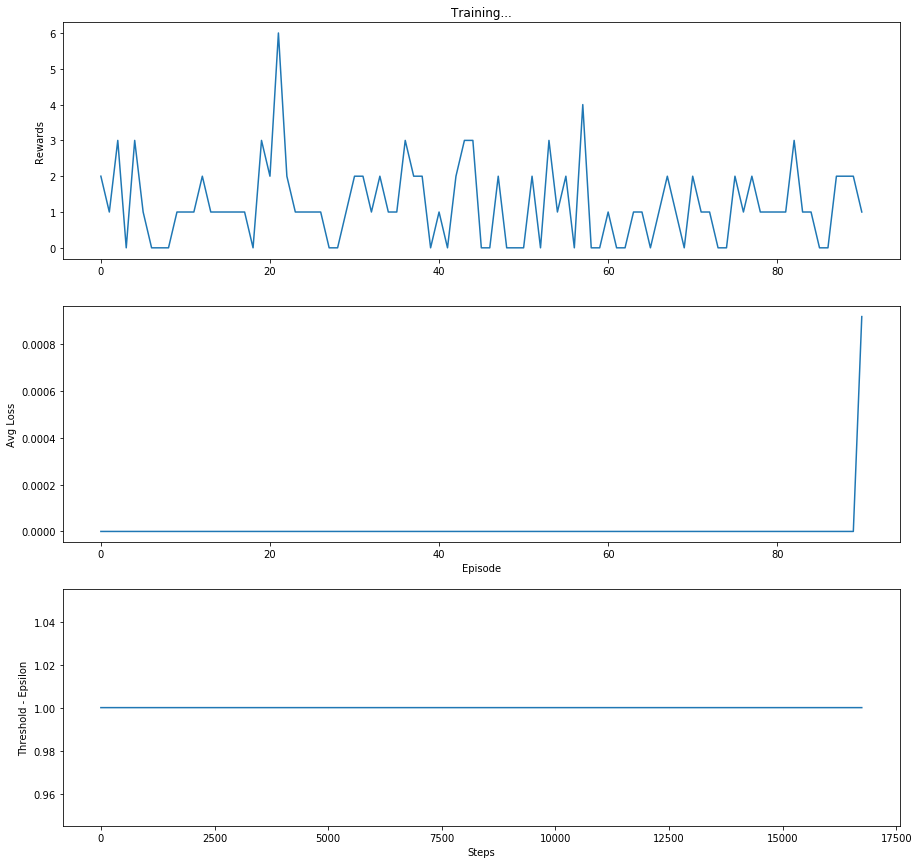

KeyboardInterrupt: 

In [10]:
from IPython.display import clear_output

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
screen_batch, screen_channel, screen_height, screen_width = init_screen.shape

memory = ReplayMemory(MEMORY_CAPACITY)

steps_done = 0

for i_episode in range(NUM_EPISODES):
    
    # Initialize the environment and state
    env.reset()
    reward_list = []
    total_reward = 0
    total_loss = 0

    frame_buffer = FrameBuffer(shape=(screen_batch, screen_channel, screen_height, screen_width))
    s = get_screen()

    frame_buffer.push(s)
    state = frame_buffer.pull()
    
    for t in range(MAX_EPISODE_LENGTH):
        
        # Select and perform an action
        action = select_action(state)
        
        _, reward, done, _ = env.step(action.item())

        # Sum rewards
        reward = torch.tensor([reward], device=device)
        total_reward += reward
        
        # Get next state with frame buffer
        next_s = get_screen()
        frame_buffer.push(next_s)
        next_state = frame_buffer.pull()
        
        # Store the transition in memory (for Replay)
        experience = state, action, reward, next_state, done

        memory.store(experience)
        
        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        total_loss += loss if loss else 0
        
        if done:
            episode_rewards.append(total_reward)
            episode_loss.append(total_loss / t)
            clear_output(True)
            plot_rewards()
            break
        else:
            state = next_state
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Save model
    if i_episode % (TARGET_UPDATE * 5) == 0:
        torch.save(target_net.state_dict(), 'model/target_net_state_dict.pt')

print('Complete')
#env.render()
env.close()